Source: https://spikeinterface.github.io/blog/ground-truth-comparison-and-ensemble-sorting-of-a-synthetic-neuropixels-recording/

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from collections import defaultdict
# from matplotlib_venn import venn3

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.qualitymetrics as sqm
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
from spikeinterface.comparison import GroundTruthStudy

from probeinterface.plotting import plot_probe

%matplotlib inline

In [3]:
def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Definiting paths and loading data (raw recording and ground truth sorting)

In [4]:
study_path = Path.home()/'Desktop'/'disk2'/'gt_study'
study_folder = study_path / 'study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/'

data_path = Path.home()/'Desktop'/'disk2'/'data2'/'dandi_mearec_simulated'/'000034'/'sub-MEAREC-250neuron-Neuropixels'
data_filename = data_path / 'sub-MEAREC-250neuron-Neuropixels_ecephys.nwb'

In [5]:
recording, ground_truth_sorting = se.read_nwb(data_filename, load_sorting=True)

/home/ikharitonov/anaconda3/envs/si_env/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/ikharitonov/anaconda3/envs/si_env/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/ikharitonov/anaconda3/envs/si_env/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


In [6]:
print(recording)
print(ground_truth_sorting)

NwbRecordingExtractor: 384 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                       600.00s (10.00 minutes) - float32 dtype - 27.47 GiB
  file_path: /home/ikharitonov/Desktop/disk2/data2/dandi_mearec_simulated/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb
NwbSortingExtractor: 250 units - 1 segments - 32.0kHz
  file_path: /home/ikharitonov/Desktop/disk2/data2/dandi_mearec_simulated/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb


## Exploring the data: units and channels

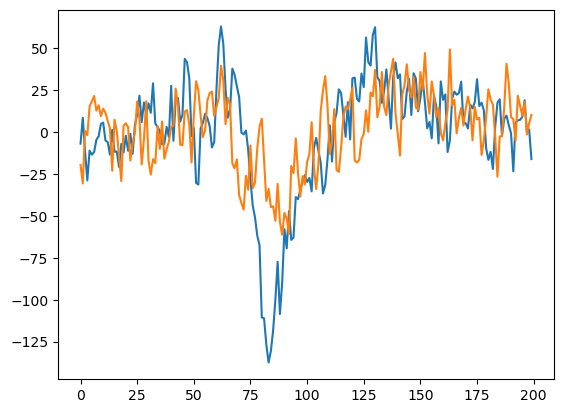

In [7]:
data_channel_100 = recording.get_traces(segment_index = 0, start_frame=150, end_frame = 350, channel_ids= [100])
data_channel_101 = recording.get_traces(segment_index = 0, start_frame=150, end_frame = 350, channel_ids= [101])

plt.plot(data_channel_100)
plt.plot(data_channel_101)

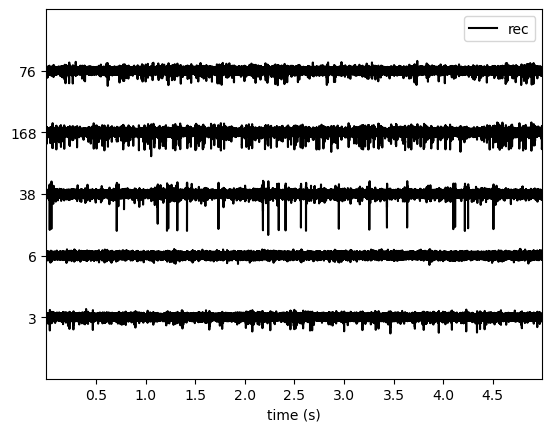

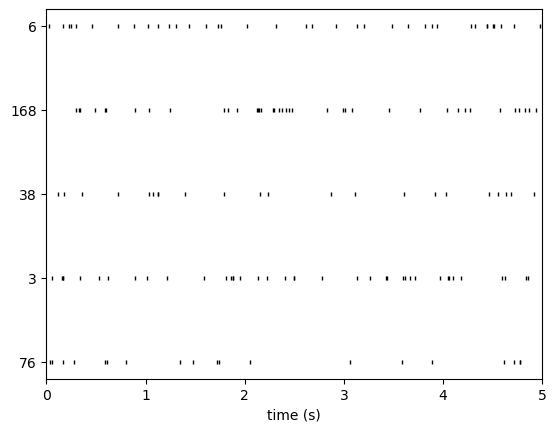

In [8]:
# channels_to_show = [x for x in range(20)]
channels_to_show = [76,3,38,168,6]

w_ts = sw.plot_timeseries(recording, time_range=(0, 5), channel_ids=channels_to_show, order_channel_by_depth=True, show_channel_ids=True)
w_rs = sw.plot_rasters(ground_truth_sorting, time_range=(0, 5), unit_ids=channels_to_show)

# units != channels

In [9]:
print(f'Sampling frequency = {recording.get_sampling_frequency()} | Number of channels = {recording.get_num_channels()} | Number of segments = {recording.get_num_segments()}')
print(f'Channel ids = {recording.get_channel_ids()}')

Sampling frequency = 32000.0 | Number of channels = 384 | Number of segments = 1
Channel ids = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 

In [10]:
unit_ids = ground_truth_sorting.get_unit_ids()

print(f'Number of segments = {recording.get_num_segments()} \nUnit ids = {unit_ids} \nSpike train of first unit = {ground_truth_sorting.get_unit_spike_train(unit_id=unit_ids[0])}')

Number of segments = 1 
Unit ids = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237

In [11]:
print(ground_truth_sorting.get_unit_spike_train(unit_id=unit_ids[0]).shape)
print('3966 spikes for first unit')

(3966,)
3966 spikes for first unit


Probe - 384ch - 1shanks


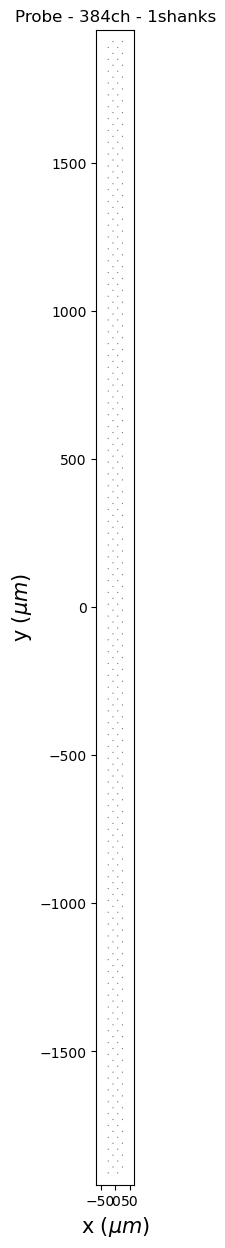

In [12]:
probe = recording.get_probe()
print(probe)

fig = plt.figure(figsize = (5,15))

probe_plot,_ = plot_probe(probe,ax=plt.gca())

## Running comparative sorting with GroundTruthStudy

In [13]:
if not os.path.isdir(study_folder):
    gt_dict = {'rec0' : (recording, ground_truth_sorting) }
    study = GroundTruthStudy.create(study_folder, gt_dict)
else: study = GroundTruthStudy(study_folder)

write_binary_recording with n_jobs = 1 and chunk_size = 32000


write_binary_recording:   0%|          | 0/600 [00:00<?, ?it/s]

In [15]:
sorter_list = ['hdsort', 'ironclust', 'kilosort3',
               'kilosort', 'mountainsort5']
sorter_names = ['HDsort', 'Ironclust', 'Kilosort3',
               'Kilosort', 'MountainSort5']
sorter_names_short = ['HS', 'IC', 'KS3', 'KS', 'MS5']

singularity_images = {
    "hdsort": "/home/ikharitonov/hdsort-compiled-base.sif",
    "ironclust": "/home/ikharitonov/ironclust-compiled-base.sif",
    "kilosort3": "/home/ikharitonov/kilosort3-compiled-base.sif",
    "kilosort": "/home/ikharitonov/kilosort-compiled-base.sif",
    "mountainsort5": "/home/ikharitonov/mountainsort5-base.sif"}

study.run_sorters(sorter_list, mode_if_folder_exists='keep', engine='loop', singularity_images=singularity_images, verbose=True)

study.copy_sortings()

Starting container
Installing spikeinterface==0.98.2 in /home/ikharitonov/mountainsort5-base.sif
Running mountainsort5 sorter inside /home/ikharitonov/mountainsort5-base.sif
Stopping container


FileNotFoundError: [Errno 2] No such file or directory: '/home/ikharitonov/Desktop/disk2/gt_study/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/sorter_folders/rec0/mountainsort5/spikeinterface_job.json'

In [ ]:
# sorting = ss.run_sorter('ironclust',recording=recording,output_folder="ironclust",singularity_image='/home/ikharitonov/ironclust-compiled-base.sif', verbose=True)

In [ ]:
# # compute or load SNR for the ground truth units
# snr_file = study_folder / 'snr.npy'
# if os.path.isfile(snr_file):
#     snr = np.load(snr_file)
# else:
#     print('computing snr')
#     # note this is quite slow for a NWB file as the data is arranged as channels:time
#     # it is faster to first write out a binary file in time:channels order
#     # snr = sqm.compute_snrs(SX_gt, RX, apply_filter=False, verbose=False, 
#     #                                  memmap=True, max_spikes_per_unit_for_snr=500)
#     snr = sqm.compute_snrs(recording)
#     np.save(snr_file, snr)